In [63]:
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
# import shutup; shutup.please()
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import sklearn as skl
from sklearn.cluster import *
from sklearn.preprocessing import StandardScaler
from librosa.feature import *
from sklearn.manifold import *
from sklearn.metrics import confusion_matrix

# Introduction

In this project I am interested in classifying different music genres based on a sample of 90 audio clips. The main goals includes extracting meaningful musical features, reducing dimensionality of the feature matrix for better visualization, perform classification via K-means and at last, evaluating the classification result based on Silhouette score. The audio data is collected from randomly selected songs in iTunes. The number of genres was pre-specified by the course instructor to ensure a meaningful result can be derived.

# Feature Engineering 

In [2]:
y=[None]*90
y_harmonic =[None]*90
y_percussive =[None]*90
sr=[None]*90
for i in range(90):
    y[i], sr[i] = librosa.load("data/" + str(i) +".mp3", sr=None)
    y_harmonic[i], y_percussive[i] = librosa.effects.hpss(y[i])
    
sr = sr[0]

### Frequency Domain Feature: Constant-Q Transform and Chroma

The main idea is to extract features related to 12 chroma masters. By applying constant-Q transformation, one is able to identify the sound frequency (chroma) out of 12 classes at each time point. Technically, the sound frequency defined in this manner ranges from 0 to 1. Below is a sample choromagram. In order to generate a useable feature vector for dissimilarity calculation, I use the following method: a sound signal is counted if its frequency is greater than 0.5, and ignored otherwise. As a result, we should get a 12-dimensional vector for each audio, where the rows give the number of strong signals corresponding to some pitch class.

**Code:** Take audio files as input, use "chroma_cqt" function from librosa to exract chromagram, and count the number of strong signals (>0.5) for each pitch class.

In [3]:
Chroma_df2=np.zeros((90,12))

def Chroma_master(y,sr):
    chroma_cqt=librosa.feature.chroma_cqt(y,sr)
    return (chroma_cqt >=0.5).sum(axis=1)

for i in range(90):
    feature_j = Chroma_master(y[i],sr)
    Chroma_df2[i,:]=feature_j
Chroma_df2 = pd.DataFrame(Chroma_df2,columns = ['Chroma_'+str(i+1)+'_master' for i in range(12)])  

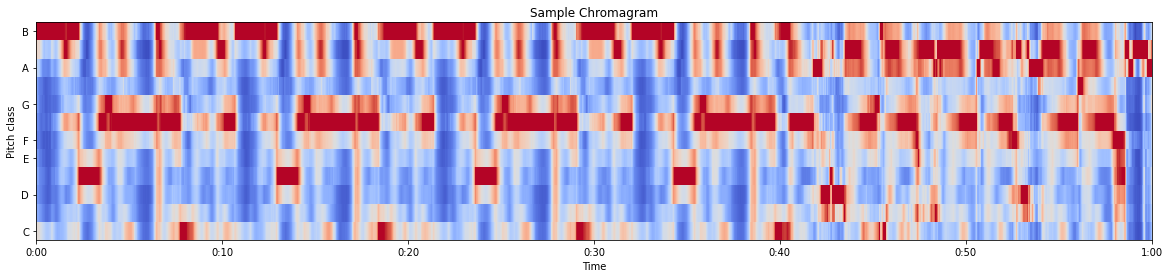

In [4]:
chromagram = librosa.feature.chroma_cqt(y[0], sr=sr)
plt.figure(figsize=(20, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.title('Sample Chromagram')
plt.show()

### Time Domain Feature: Time Between Beats

To understand the general rhythm of a song, one may consider tempo feature like "number of beats per minute". Alternatively, "average time between beats" is used in our case, which measures the same information as beats per minute. Calculation of this temp feature relies on the function provided by librosa. The resulting vector will be 1-dimensional.

In [5]:
n=90
time_between_beats=np.zeros((n,))

for i in range(90):
    tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic[i], sr=sr)
    beat_times = librosa.frames_to_time(beat_frames, sr=sr)
    time_between_beats[i]=np.diff(beat_times).mean()

np.where(np.isnan(time_between_beats)) # File 78 does not have beat. so replace nan with 0 
time_between_beats=np.nan_to_num(time_between_beats)

df_2 = pd.DataFrame({'beat_time':time_between_beats})
time_between_beats[time_between_beats==0]=time_between_beats.mean()

### Spectrum-based Feature: MFCCs


In sound processing, the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. Mel-frequency cepstral coefficients are coefficients that collectively make up an MFC.

* **Determining how many MFCCs to use**

All MFCCs for each piece of music sample are calculated, which yield 5 sample density distributions. One can notice that the coefficients tagged "0" and "1" in the plot exhibits higher volatility than the others. A screeplot of their standard deviations gives a numerical measure of such difference. In other words, coefficient "0" and "1" may be sufficient already in distinguishing different music genres. Therefore, only the first two MFCCs are adopted as features. The result is a 2-dimensional vector.

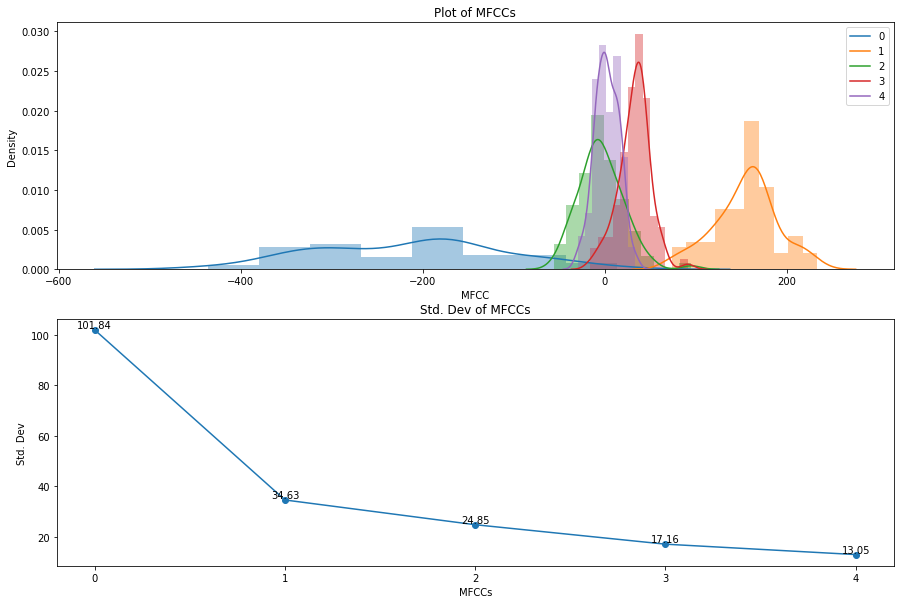

In [6]:
def get_mfcc(y, sr=44100, n=2):
    # get mean of each MFCC, result is 1*n_mfcc vector
    
    mfcc_ = mfcc(y, sr, hop_length=512, n_mfcc=5)[0:n,:]
    mfcc_mean = mfcc_.mean(axis=1).reshape((1,-1))[0]
    
    return mfcc_mean

n_mfcc = 5
mfcc_df = pd.DataFrame(columns=np.arange(n_mfcc))
mfcc_df.columns = [str(x) for x in np.arange(n_mfcc)]

for yi in y:
    mfcc_mean = get_mfcc(yi, n=5)
    mfcc_df.loc[len(mfcc_df)] = mfcc_mean

    
# EDA
lab = np.arange(0,n_mfcc)
std = [round(_, 2) for _ in list(mfcc_df.std())]

plt.figure(figsize=(15,10))
plt.subplot(211)
for i in mfcc_df.columns:
    sns.distplot(mfcc_df[i], kde=True)
plt.title('Plot of MFCCs')
plt.xlabel('MFCC')
plt.ylabel('Density')
plt.legend(mfcc_df.columns)

plt.subplot(212)
plt.plot(std, 'o-')
plt.xlabel('MFCCs')
plt.ylabel('Std. Dev')
plt.xticks(lab)
for i, txt in enumerate(std):
    plt.annotate(txt, (lab[i], std[i]), ha='center', va='bottom')
plt.title("Std. Dev of MFCCs")

plt.show()


### Spectrum-based Feature: Spectral Flatness


Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to being tone-like. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. Each audio file will produce a time series of spectral flatness. For our purpose, To reduce dimensionality, the median spectral flatness is used instead. The output is a 1-dimensional feature vector.


### Time Domain Feature: Zero-Crossing Rate (ZCR)

The zero-crossing rate (ZCR) is the rate at which the sound signal changes from positive to zero to negative or from negative to zero to positive. It is helpful in detecting the general pattern of the music.

In [7]:
def get_flatness_median(y):
    flatness = spectral_flatness(y)
    return np.median(flatness)
    
    
def get_zcr_median(y):
    zcr = zero_crossing_rate(y)
    return np.median(zcr)

feature_df = pd.DataFrame(columns=['median_flatness', 'median_zcr', 'mfcc1', 'mfcc2'])
for yi in y:
    
    # features
    flat_med = get_flatness_median(yi)
    zcr_med = get_zcr_median(yi)
    mfcc1, mfcc2 = get_mfcc(yi)
    
    # import into dataframe
    cur = len(feature_df)
    feature_df.loc[cur] = [flat_med, zcr_med, mfcc1, mfcc2]

features = pd.concat([Chroma_df2,df_2,feature_df],axis=1)


## Features Summary

We build our feature matrix based on three classes of musical features, which are: time domain features, frequency domain features and spectrum shape based features. A brief summary below:

+ `beat_time`: The average time difference between two concecutive beats.
+ `Chroma_i_master`: The number of strong beats in the i-th row (representing one of the 12 pitches [C, C#, D, D# ,E, E#, F, F#, G, G#, A, A#, B]) of the chromagram matrix.
+ `Median_Flatness`: The median of spectral flatness of an audio clip. (Mdian instead of mean is used to minimize the impact of outliers)
+ `Median Zero-Crossing Rate`: The median of Zero-Crossing rate of an audio clip.
+ `MFCCs (1,2)`: The first two Mel-frequency cepstral coefficients, which are also the most influencial among all. 

**The resulting column space of the feature matrix is thus 17-dimensional**

# Dimension Reduction

##### Linear PCA

The principal component analysis gives a linear projection of our data onto orthogonal axis to possibly maximize the overall variability in a low dimensional space. From the plot below, which visualizes the projection of our data onto the first two eigenvectors of its covariance matrix, we can hardly find any meaningful cluster structures. It indicates that our data **may not be linearly seperable.**

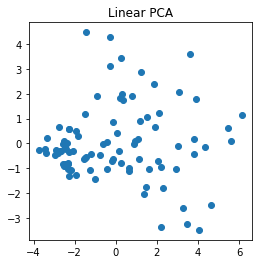

In [8]:
scaler= StandardScaler()
scaled_features = scaler.fit_transform(features)

pca = skl.decomposition.PCA()
pca = pca.fit(scaled_features)

pca_feature = pca.transform(scaled_features)

fig =plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.scatter(pca_feature[:, 0], pca_feature[:, 1])
plt.title("Linear PCA")
plt.axis('tight')
plt.show()

#### Kernel PCA

The kernel PCA may work better with non-linear structures by introducing a kernel function, which is to be applied to the standard-scaled dataset before projecting it onto a lower dimension space. In our case, the Gaussian kernel is used. From the result below, one can observe a **rough triangular pattern**, which **confirms the non-liearnity** of the input dataset. Though, it **still does not seperate our data very well.**

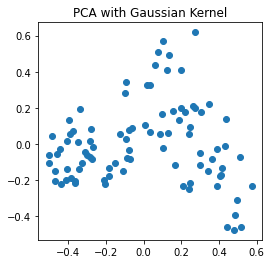

In [9]:
scaler= StandardScaler()
scaled_features = scaler.fit_transform(features)

kpca = skl.decomposition.KernelPCA(kernel='rbf')
kpca = kpca.fit(scaled_features)

kpca_feature = kpca.transform(scaled_features)

plt.figure(figsize=(4,4))
plt.scatter(kpca_feature[:, 0], kpca_feature[:, 1])
plt.title("PCA with Gaussian Kernel")
plt.axis('tight')
plt.show()

#### Multi-Dimensional Scaling

The MDS is another non-linear method that attempts to reduce dimensionality such that the resulting distances well respect the pairwise distances of the data in its original higher-dimensional space. In our case, MDS **performs poorly** as its lower-dimensional projection looks very **close to white noise.**

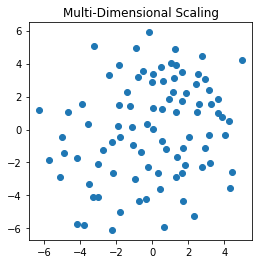

In [10]:
Y0 = MDS(n_components=2).fit_transform(scaled_features)

fig =plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.scatter(Y0[:, 0], Y0[:, 1], cmap=plt.cm.Spectral)
plt.title("Multi-Dimensional Scaling")
plt.axis('tight')
plt.show()


### Isomap

The Isomap algorithm uses similar dimension reduction method to MDS. However, it aims to preserve geodesic distance on a manifold instead of euclidean distance that is used in MDS. Its advantage is that it takes into account the "general shape" of input dataset and finds pairwise distances in a manifold-based graph instead of on a hyperplane. From the plot below, one can see that, similar to kernel PCA, **a rough triangular pattern** is revealed. However, the result is **still not quite linearly seperable.**

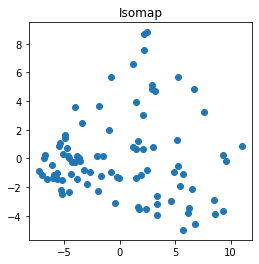

In [11]:
n_neighbors = 6
n_components = 2
Y = Isomap(n_neighbors=n_neighbors, n_components=n_components).fit_transform(scaled_features)

fig =plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
plt.title("Isomap")
plt.axis('tight')
plt.show()


### Locally Linear Embedding

Locally linear embedding tries to reduce dimensionality while also preserving the local dissimilarity structure of each k-NN neighborhood corresponding to each point. By visually comparing LLE to previous methods, the low-dimensional representation it creates **gives the best result** as one can see a very clear triangular shape. Points are **very well seperated into three clusters**. Such visualization also gives us useful insight in choosing the number of clusters.

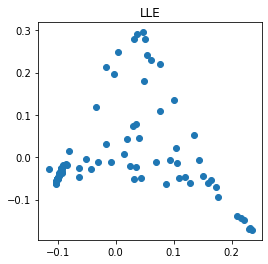

In [12]:
lle = LocallyLinearEmbedding(n_neighbors=4, n_components=2, random_state=2022)
Y2 = lle.fit_transform(scaled_features)

fig =plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
plt.scatter(Y2[:, 0], Y2[:, 1], cmap=plt.cm.Spectral)
plt.title("LLE")
plt.axis('tight')
plt.show()

**Conclusion:** In total, the performance of five dimension reduction techniques are explored based on the 90 music samples. It seems that **Locally Linear Embedding gives the best result** in terms of exhibiting the 17-dimensional feature matrix in a 2-dimensional space and in a linearly seperable manner. Based on the visualization, we further hypothesize that the true number of clusters is equal to 3, or that the 90 music samples comes from **3 different music genres.**

# Classification via K-Means

After applying Locally Linear Embedding, the low-dimensional representation of the sound features looks quite linearly seperable. We can thus apply K-Means to classify the audio data. We hypothesize that the 90 music sample consists of 3 different music genres as points in the lower-dimensional representation exhibits a clear triangular pattern. Also, further increasing the number of clusters from 3 to 4 does not reduce sample sum of squared distance significantly based on the screeplot. Therefore, k is set to be 3 in our case. A visualization of the initial clustering result is given below.

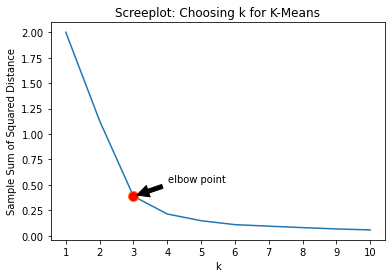

In [13]:
elb_lst=[]
for i in range(1,11):
    km = KMeans(i, random_state=0).fit(Y2)
    elb_lst.append(km.inertia_)
    
plt.figure(figsize=(6,4))
plt.plot(range(1,11),elb_lst)
plt.xticks(np.arange(1,11))
plt.title("Screeplot: Choosing k for K-Means")
plt.xlabel("k")
plt.ylabel("Sample Sum of Squared Distance")
plt.plot([3], elb_lst[2], marker="o", markersize=10, markerfacecolor="red")
plt.annotate('elbow point', xy=(3, elb_lst[2]),  xycoords='data',
            xytext=(0.35, 0.3), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.1),
            horizontalalignment='left', verticalalignment='top',
            )
plt.show()

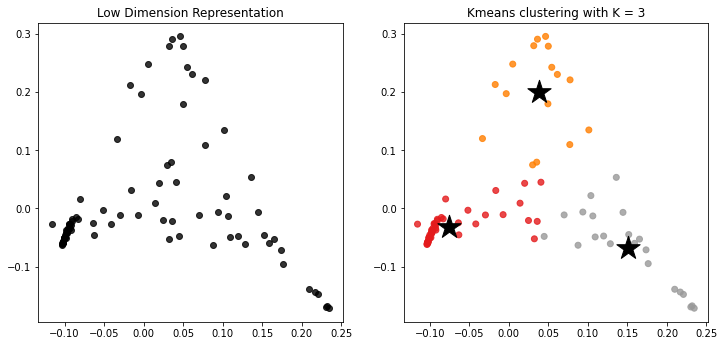

In [14]:
K=3
X=Y2
km = KMeans(K, random_state=0).fit(X)
cluster_labels = km.labels_
centroids = km.cluster_centers_
figx = plt.figure(figsize=(12,5.5))
ax = figx.subplots(1,2)

ax[1].set_title("Kmeans clustering with K = {}". format(K)) 
ax[1].scatter(X[:,0],X[:,1], c = cluster_labels,
                     cmap ='Set1',alpha=0.8)
ax[1].scatter(centroids[:,0],centroids[:,1], s = 20*30,marker = '*',color='black')

ax[0].set_title('Low Dimension Representation') 
ax[0].scatter(X[:,0],X[:,1], c = 'black',
                     cmap ='Set1',alpha=0.8)

plt.show()

### Evaluating Clustering results

The **average silhouette score** is used as a metric to evaluate our clustering result. A silhouette score is calculated using the formula (a-b)/max(a,b), where "a" is the mean intra-cluster distance and "b" is the mean inter-cluster distance from the nearest cluster. A silhouette score can range from 1 to -1. More specifically, a silhouette score of 1 indicates perfect seperation of a cluster to its nearest neighbor; a silhouette score of 0 indicates significant overlapping and thus ineffective decision boundary; a silhouette score of -1 indicates incorrect cluster assignment. In short, **the closer the score is to 1, the better the quality of clustering**.

The silhouette scores for all clusters using different values of k have been calculated and shown below. We can thus compare several possible choices of "k" and also see the quality of clustering for each specific cluster. We say that a good clustering result should achieve:
+ Higher silhouette score on average
+ Minimal presence of clusters with below average silhouette scores
+ Minimal presence of negative silhouette scores
+ Small fluctuation in size and quality of clustering


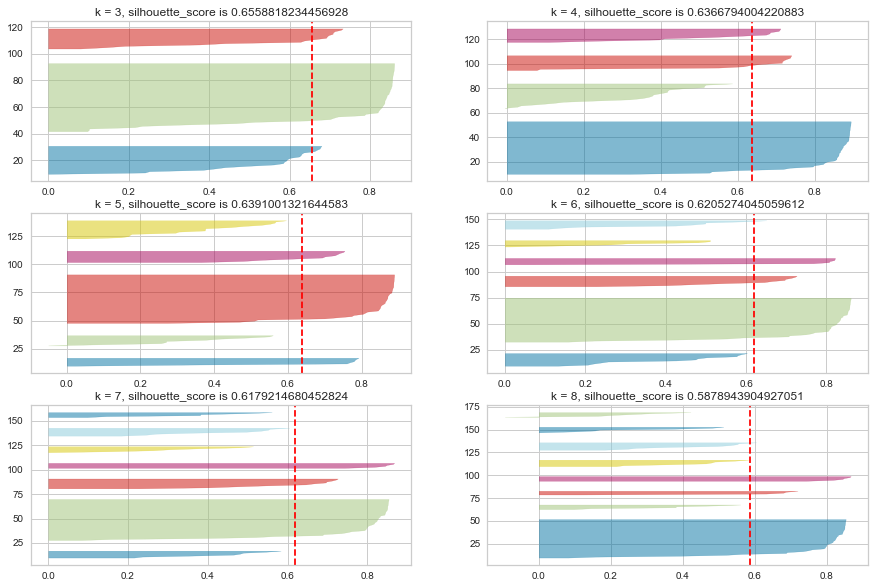

In [15]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X, km.labels_)

from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(3, 2, figsize=(15,10))
for i in [3, 4,5,6,7,8]:
    '''
    Create KMeans instance for different number of clusters
    '''
    kmm = KMeans(n_clusters=i).fit(X)
    q, mod = divmod(i-1, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(kmm, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    ax[q-1][mod].title.set_text('k = '+str(i)+', silhouette_score is '+str(silhouette_score(X, kmm.labels_, metric='euclidean')))

Based on the above plots, it seems that setting k=3 is the optimal choice, which produces the highest average silhouette score of 0.656. The silhouette score for all 3 clusters are close to the average; no cluster has significantly lower clustering quality than the others; no unreasonable cluster assignment is found; the size of each cluster does not look unbalanced either.

# Conclusion

To get a good feature matrix, I adopt 3 classes of musical features (time domain, frequency domain and spectrum-based features) in the hope to comprehensively grasp some structral differences across different music genres. After experimenting with several of the most commonly used dimension reduction techniques, I achieve the best result using LLE (Locally Linear Embedding), which gives a linearly seperable low-rank representation of the original high-dimensional data. With k=3, I am able to get a satisfactory classification result with an average silhouette score of 0.66. 

In [76]:
!jupyter nbconvert music_classification_unsupervised.ipynb --to=pdf --TemplateExporter.exclude_input=True

[NbConvertApp] Converting notebook music_classification_unsupervised.ipynb to pdf
[NbConvertApp] Support files will be in music_classification_unsupervised_files/
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Making directory ./music_classification_unsupervised_files
[NbConvertApp] Writing 32073 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Run